In [188]:
import xml.etree.ElementTree as ET

class PDBTM:
    def __init__(self, id = str, chains = []): 
        self.id = id
        self.chains = chains
    
class Chain:
    def __init__(self, id = str, num_tm = int, typ = str, seq = str, regions = []): 
        self.id = id
        self.num_tm = num_tm
        self.typ = typ
        self.seq = seq
        self.regions = regions
    
class Region:
    def __init__(self, seq_beg = int, pdb_beg = int, seq_end = int, pdb_end = int, typ = str):
        self.seq_beg = seq_beg
        self.pdb_beg = pdb_beg
        self.seq_end = seq_end
        self.pdb_end = pdb_end
        self.typ = typ

In [189]:
import os
from shutil import copyfile

def filter_for_tmps(path):
    counter = 0
    for root, dirs, files in os.walk(path):
        for name in files:
            if name.endswith(".xml"): 
                path = os.path.join(root,name)
                pdbtm_xml = ET.parse(path) 
                pdbtm_root = pdbtm_xml.getroot()
                is_tmp = pdbtm_root.attrib.get('TMP')
                if is_tmp == 'yes':
                    print("Copy", pdbtm_root.attrib.get("ID"))
                    copyfile(path, os.path.join("pdbtm_xmls",name))
                    counter = counter + 1
                        
    return counter
                
#number_of_tms = filter_for_tmps("pdbtm/database")    
#print(number_of_tms)

In [217]:
def parse_pdbtm_xmls(paths):
    '''
    Parses PDBTM XML files to a list od PDBTM Objects.
    A PDBTM Object contains the PDB ID as well as a list of Chain objects. 
    A Chain Object contains the chain ID, the tm number, the type, the sequence and a list of Region objects.
    A Region object contains the begin and end indices of the sequence and the pdb file, as well as the type.
    '''
    ns = {'pdbtm': 'http://pdbtm.enzim.hu'}
    pdbtms = []
    for path in paths:
        pdbtm_xml = ET.parse(path) 
        pdbtm_root = pdbtm_xml.getroot()
        pdbtm_id = pdbtm_root.attrib.get('ID')
        
        if pdbtm_root.attrib.get('TMP') == 'yes':
            chains = []
            for chain_xml in pdbtm_root.findall('pdbtm:CHAIN', ns):
                chain_id = chain_xml.attrib.get('CHAINID')
                num_tm = chain_xml.attrib.get('NUM_TM')
                typ = chain_xml.attrib.get('TYPE')
                seq = chain_xml.find('pdbtm:SEQ', ns)

                regions = []
                for region_xml in chain_xml.findall('pdbtm:REGION', ns):
                    seq_beg = region_xml.attrib.get('seq_beg')
                    pdb_beg = region_xml.attrib.get('pdb_beg')
                    seq_end = region_xml.attrib.get('seq_end')
                    pdb_end = region_xml.attrib.get('pdb_end')
                    typ_region = region_xml.attrib.get('type')
                    region = Region(seq_beg, pdb_beg, seq_end, pdb_end, typ_region)
                    regions.append(region)
            chain = Chain(chain_id, num_tm, typ, seq.text.replace(" ", "").replace("\n", ""), regions)
            chains.append(chain) 

            pdbtm = PDBTM(pdbtm_id, chains)
            pdbtms.append(pdbtm)
        
        else:
            print(pdbtm_id, "is no TMP and was ignored.")
    
    return pdbtms

In [218]:
paths = []
for file in os.listdir("pdbtm_xmls"):
    if file.endswith(".xml"):
        path = os.path.join("pdbtm_xmls", file)
        paths.append(path.strip())
        
pdbtms = parse_pdbtm_xmls(paths)

In [219]:
helix_pdbtms = []
for pdbtm in pdbtms:
    for chain in pdbtm.chains:
        if chain.typ == "alpha":
            for region in chain.regions:
                if region.typ == "H":
                    helix = chain.seq[int(region.seq_beg):int(region.seq_end)]
                    helix_pdbtms.append(helix)

In [231]:
import collections
pdbtm_helices_aas = collections.Counter()
for helix in helix_pdbtms:
    pdbtm_helices_aas = pdbtm_helices_aas + collections.Counter(helix)

<function matplotlib.pyplot.show(*args, **kw)>

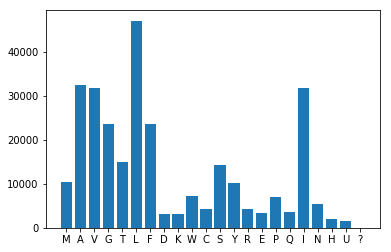

In [235]:
import matplotlib.pyplot as plt
plt.bar(range(len(pdbtm_helices_aas)), list(pdbtm_helices_aas.values()), align='center')
plt.xticks(range(len(pdbtm_helices_aas)), list(pdbtm_helices_aas.keys()))
plt.show